# Homework project for the "Differential Equations" course module

1. Solve the wave equation `d^2t u(t,x) = d^2x u(t,x)` numerically. Use a `1+1`-dimensional domain, and use Dirichlet boundary conditions `u(t,-L) = u(t,+L) = 0`. Use the spatial domain bounds `[-1; +1]`, and use the Gaussian-like function `f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)` as initial condition. Use `L=1, A=1, W=0.2` as parameters. Evolve from `t=0` to `t=4L`, i.e. for two crossing times. Plot the result.

2. Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

3. The energy density of a scalar wave is `epsilon(t,x) = 1/2 ((d/dt u(t,x))^2 + ((d/dx u(t,x))^2)`. Calculate the energy density as a function of space and time for your solution. Plot the result.

4. To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt`?

***

### 1) Solving wave equation
\begin{equation}
\partial_{xx} u(t,x) = \partial_{tt} u(t,x)
\end{equation}

1. Solve the wave equation `d^2t u(t,x) = d^2x u(t,x)` numerically. Use a `1+1`-dimensional domain, and use Dirichlet boundary conditions `u(t,-L) = u(t,+L) = 0`. Use the spatial domain bounds `[-1; +1]`, and use the Gaussian-like function `f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)` as initial condition. Use `L=1, A=1, W=0.2` as parameters. Evolve from `t=0` to `t=4L`, i.e. for two crossing times. Plot the result.

In [369]:
using CairoMakie
# Parameters
L = 1
A = 1
W = 0.2;

# Boundary conditions
# u(t,-L) = 0
# u(t,+L) = 0;

In [370]:
function coords(nn, ni, dt, dx)
    t = [n * dt for i in 0:ni, n in 0:nn]
    x = [(i * dx)-1 for i in 0:ni, n in 0:nn]
    return t, x
end

coords (generic function with 1 method)

In [371]:
nn = 400
ni = 200
dt = (4*L)/ (nn)
dx = (2) / (ni)

t, x = coords(nn, ni, dt, dx);
(dt,dx)

(0.01, 0.01)

In [372]:
function Gaussianlike(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    for n in 1:2, i in 1:ni
        u[i, n] = A * exp.(-1/2* sin.(2*π*(x[i, n]-t[i, n])).^2) / W^2
    end
    return u
end

Gaussianlike (generic function with 1 method)

In [373]:
#Test function
function Gaussian(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    for n in 1:2, i in 1:ni
        u[i, n] = sin.(x[i, n]) #A * (1-x[i, n].^2) .* sin.(x[i, n]) #exp.(-1/2*(x[i, n].^2) )/ W^2
    end
    return u
end

Gaussian (generic function with 1 method)

In [374]:
#Find the solution at one interior point u[i,n]
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
    # Finte difference for second derivative in x direction at point [i,n-1]
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1])/dx^2
    # Time derivative
    # utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n])/dt^2
    # Wave equation
    # utt = uxx
    # Solve for u[i,n]
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return 
end

evolve_point! (generic function with 1 method)

In [375]:
# Find the solution for one point in time `n`
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    #Apply boundary condtion at left boundary
    u[1,n] = 0
    #Evolve interior
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    #Apply boundary condtion at right boundary
    u[ni,n] = 0
    return
end

evolve_step! (generic function with 1 method)

In [376]:
#Find the solution everywhere
function evolve!(u, dt, dx)
    ni, nn = size(u)
    #Loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

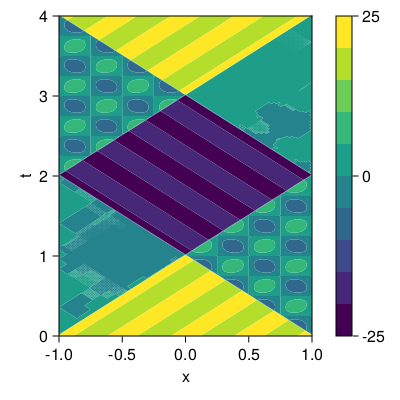

In [377]:
u = Gaussianlike(t,x);
evolve!(u, dt, dx)
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "t")
co = contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1, 2], co)
fig

Boundary condition doesn't match with the properties of the funciton. Here at boundary x=-1 and 1, the function does not have the value 0. Then there is some kind of jumping.

### 2. Stability limit
Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

- Consider when we use dt too large (larger than dx). We will investigate through the function `calculate_error` which can determine the error of the solution for Gaussianlike funciton.

In [378]:
# Calculate error
function calculate_error(t, x, u)
    ni, nn = size(u)
    err = similar(u)
    for n in 1:nn, i in 1:ni
        err[i,n] = u[i,n] .- A * exp.(-1/2*sin.(2*π*(x[i, n].-t[i, n])).^2) / W^2
    end
    return err
end

calculate_error (generic function with 1 method)

- when $dt=dx$

In [379]:
nn = 400
ni = 200
dt = (4*L)/ (nn)
dx = (2) / (ni)

t, x = coords(nn, ni, dt, dx);
(dt,dx)

(0.01, 0.01)

In [380]:
u = Gaussianlike(t,x);
evolve!(u, dt, dx)
err = calculate_error(t, x, u)
maximum(abs.(err))

50.000000000000014

- when $dt<dx$

In [381]:
nn2 = 800
ni2 = 200
dt2 = (4*L)/ (nn2)
dx2 = 2/ (ni2)

t2, x2 = coords(nn2, ni2, dt2, dx2);
(dt2,dx2)

(0.005, 0.01)

In [382]:
u2 = Gaussianlike(t2,x2);
evolve!(u2, dt2, dx2)
err2 = calculate_error(t2, x2, u2)
maximum(abs.(err2))

60.28923235567213

- when $dt>dx$

In [383]:
nn3 = 200
ni3 = 200
dt3 = (4*L)/ (nn3)
dx3 = 2/ (ni3)

t3, x3 = coords(nn3, ni3, dt3, dx3);
(dt3,dx3)

(0.02, 0.01)

In [384]:
u3 = Gaussianlike(t3,x3);
evolve!(u3, dt3, dx3)
err3 = calculate_error(t3, x3, u3)
maximum(abs.(err3))

8.579970777863622e224

We can see that when dt is larger than dx, the error is very high. This stability limit can be defined by this situation which means there is some limit that our algorithm fails. This error arises when we use the $dt > dx$ because we can show that the accumulated error related to $\frac{dt}{dx}$, $\frac{dt}{dx}*error$, then if we use $\frac{dt}{dx}<1$, we can avoid the accumulated error.

### 3. The energy density 
The energy density of a scalar wave is `epsilon(t,x) = 1/2 ((d/dt u(t,x))^2 + ((d/dx u(t,x))^2)`. Calculate the energy density as a function of space and time for your solution. Plot the result.

In [385]:
function epsilon(u,dx,dt,nn,ni)
    ∂ₜu = copy(u)
    ∂ₓu = copy(u)
    for i in 1:ni, n in 1:nn
        ∂ₓu[i,n] = (u[i+1,n] - u[i,n]) ./ (dx)
        ∂ₜu[i,n] = (u[i,n+1] - u[i,n]) ./ (dt)
    end
    return (∂ₜu.^2 + ∂ₓu.^2)./2
end

epsilon (generic function with 1 method)

In [395]:
nn = 400
ni = 200
dt = (4*L)/ (nn)
dx = (2) / (ni)

t, x = coords(nn, ni, dt, dx);
(dt,dx)
u = Gaussianlike(t,x)
evolve!(u, dt, dx)
e = epsilon(u,dx,dt,nn,ni);
(dx,dt)

(0.01, 0.01)

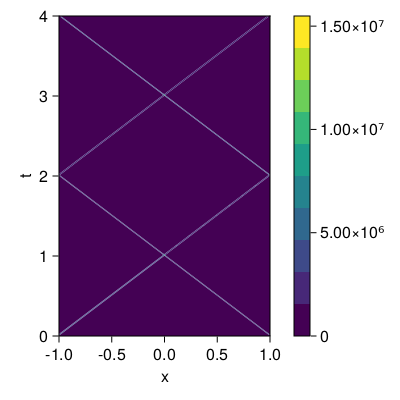

In [396]:
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "t")
co = contourf!(vec(x), vec(t), vec(e))
Colorbar(fig[1, 2], co)
fig

As we can see, the jumping regions make very high derivative. Then, the energy density is very high in that regions

### 4. Calculate the total energy
To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt`?

In [397]:
# Integrate `epsilon` over space
function integrate(epsilon, n, dx)
    ni, nn = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    # Scale by the grid spacing
    E *= dx
    return E
end

integrate (generic function with 1 method)

In [398]:
nn = 400
ni = 200
dt = (4*L)/ (nn)
dx = (2) / (ni)

t, x = coords(nn, ni, dt, dx);
(dt,dx)

(0.01, 0.01)

In [399]:
n = [i for i in 1:nn]
#e = 1 .+ zero(rand(ni,nn))
E = integrate(e,n,dx);
t = [i * dt for i in 1:nn];

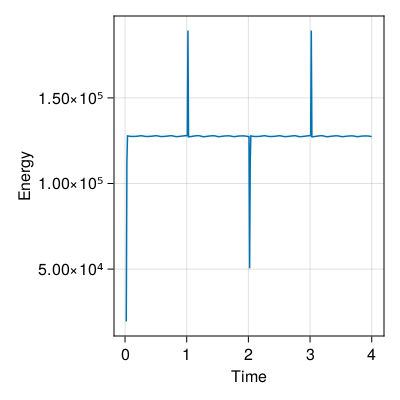

In [400]:
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Energy")
#ylims!(ax,19,21)
lines!(t[2:nn],E[2:nn])
fig

The result has changed if we have a large step size (large dx,dt), and there are some problem when calculate the energy density around the suddenly change of the solution (t= {0,1,2,3}).

***